In [13]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


In [14]:
# Adjust path if needed
diabetes = pd.read_csv("../data/diabetes.csv")
heart = pd.read_csv("../data/heart_cleveland_upload.csv")
liver = pd.read_csv("../data/indian_liver_patient.csv")

print("Diabetes:", diabetes.shape)
print("Heart:", heart.shape)
print("Liver:", liver.shape)


Diabetes: (768, 9)
Heart: (297, 14)
Liver: (583, 11)


In [5]:
# Liver dataset target column sometimes named 'Dataset'
if "Dataset" in liver.columns:
    liver = liver.rename(columns={"Dataset": "target"})

# Convert 1 → disease, 2 → no disease
liver["target"] = liver["target"].map({1: 1, 2: 0})


In [15]:
print("Diabetes columns:", diabetes.columns.tolist())
print("Heart columns:", heart.columns.tolist())
print("Liver columns:", liver.columns.tolist())


Diabetes columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
Heart columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition']
Liver columns: ['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio', 'Dataset']


In [16]:
# Rename liver target column
if "Dataset" in liver.columns:
    liver = liver.rename(columns={"Dataset": "target"})

# Convert values if present (1 = disease, 2 = no disease)
if liver["target"].nunique() == 2:
    liver["target"] = liver["target"].map({1:1, 2:0})


In [19]:
heart_target = "condition"
print("Heart target column:", heart_target)


Heart target column: condition


In [11]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [22]:
from sklearn.preprocessing import OneHotEncoder

def train_model(df, target_col, model_name):

    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Identify numeric and categorical columns
    numeric = X.select_dtypes(include=['number']).columns.tolist()
    categorical = X.select_dtypes(exclude=['number']).columns.tolist()

    print(f"\nTraining {model_name}...")
    print("Numeric columns:", numeric)
    print("Categorical columns:", categorical)

    # Preprocessing: numeric + categorical
    preprocessor = ColumnTransformer([
        ("num", SimpleImputer(strategy="median"), numeric),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical)
    ])

    model = Pipeline([
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
    ])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

    os.makedirs("../models", exist_ok=True)
    joblib.dump(model, f"../models/{model_name}.pkl")
    print(f"✔ Saved model: ../models/{model_name}.pkl")

    return model


In [23]:
diabetes_model = train_model(diabetes, "Outcome", "diabetes_model")

heart_model = train_model(heart, "condition", "heart_model")

liver_model = train_model(liver, "target", "liver_model")



Training diabetes_model...
Numeric columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical columns: []
Accuracy: 0.7597402597402597
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154

✔ Saved model: ../models/diabetes_model.pkl

Training heart_model...
Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical columns: []
Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.95      0.75      0.84        28

    accuracy                           0.87  

In [24]:
MODEL_DIR = r"C:\Users\HP\multi_disease_predictor\models"

diabetes_model = joblib.load(MODEL_DIR + r"\diabetes_model.pkl")
heart_model = joblib.load(MODEL_DIR + r"\heart_model.pkl")
liver_model = joblib.load(MODEL_DIR + r"\liver_model.pkl")


In [1]:
# run in a notebook cell (prefix with !)
!pip install -q scikit-learn==1.7.2 xgboost lightgbm catboost matplotlib pandas numpy joblib


  You can safely remove it manually.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os, warnings, joblib
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# show plots in notebook
%matplotlib inline

# folder to save final best models (Windows path inside your project)
OUT_MODELS = Path(r"C:\Users\HP\multi_disease_predictor\models_best")
OUT_MODELS.mkdir(parents=True, exist_ok=True)


In [10]:
# Use your Windows data folder
DIABETES_CSV = r"C:\Users\HP\multi_disease_predictor\data\diabetes.csv"
HEART_CSV    = r"C:\Users\HP\multi_disease_predictor\data\heart_cleveland_upload.csv"
LIVER_CSV    = r"C:\Users\HP\multi_disease_predictor\data\indian_liver_patient.csv"

diabetes = pd.read_csv(DIABETES_CSV)
heart = pd.read_csv(HEART_CSV)
liver = pd.read_csv(LIVER_CSV)

print("Diabetes:", diabetes.shape)
print("Heart:", heart.shape)
print("Liver:", liver.shape)


Diabetes: (768, 9)
Heart: (297, 14)
Liver: (583, 11)


In [11]:
# Diabetes
if 'Outcome' not in diabetes.columns:
    print("Diabetes columns:", diabetes.columns.tolist())
else:
    print("Diabetes target: Outcome present")

# Heart: rename 'condition' -> 'target' if present
if 'condition' in heart.columns:
    heart = heart.rename(columns={'condition':'target'})
    print("Heart target set to 'target'")
else:
    for c in heart.columns[::-1]:
        if heart[c].nunique() == 2:
            heart = heart.rename(columns={c:'target'})
            print("Heart target auto-detected:", c)
            break

# Liver: standardize 'Dataset' -> 'target' and map 1/2 -> 1/0
if 'Dataset' in liver.columns:
    liver = liver.rename(columns={'Dataset':'target'})
    if set(liver['target'].dropna().unique()) == {1,2}:
        liver['target'] = liver['target'].map({1:1, 2:0})
        print("Liver target converted 1/2 -> 1/0")
elif 'target' in liver.columns:
    print("Liver target present:", liver['target'].unique()[:10])
else:
    print("Liver columns:", liver.columns.tolist())


Diabetes target: Outcome present
Heart target set to 'target'
Liver target converted 1/2 -> 1/0


In [13]:
from typing import Tuple

def build_preprocessor(X: pd.DataFrame):
    numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

    numeric_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ])

    if categorical_cols:
        categorical_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])
        preproc = ColumnTransformer([
            ("num", numeric_pipe, numeric_cols),
            ("cat", categorical_pipe, categorical_cols)
        ], remainder='drop')
    else:
        preproc = ColumnTransformer([
            ("num", numeric_pipe, numeric_cols)
        ], remainder='drop')

    return preproc, numeric_cols, categorical_cols

# quick checks
pre, ncols, ccols = build_preprocessor(diabetes.drop(columns=['Outcome']))
print("Diabetes numeric:", ncols, "categorical:", ccols)
pre, ncols, ccols = build_preprocessor(liver.drop(columns=['target']))
print("Liver numeric:", ncols, "categorical:", ccols)


Diabetes numeric: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'] categorical: []
Liver numeric: ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'] categorical: ['Gender']


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "GaussianNB": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42)
}

# Try optional libraries
try:
    import xgboost as xgb
    models["XGBoost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_estimators=200)
except Exception as e:
    print("XGBoost not available:", e)

try:
    import lightgbm as lgb
    models["LightGBM"] = lgb.LGBMClassifier(n_estimators=200, random_state=42)
except Exception as e:
    print("LightGBM not available:", e)

try:
    import catboost as cb
    models["CatBoost"] = cb.CatBoostClassifier(verbose=0, random_state=42, iterations=200)
except Exception as e:
    print("CatBoost not available:", e)

print("Models to run:", list(models.keys()))


Models to run: ['LogisticRegression', 'GaussianNB', 'KNN', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'SVM', 'XGBoost', 'LightGBM', 'CatBoost']


In [15]:
def evaluate_models_on_dataset(df: pd.DataFrame, target_col: str, dataset_name: str, models_dict: dict):
    df = df.dropna(subset=[target_col]).copy()
    X = df.drop(columns=[target_col])
    y = df[target_col].astype(int)

    preproc, num_cols, cat_cols = build_preprocessor(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = []
    for name, clf in models_dict.items():
        print(f"\n[{dataset_name}] Training {name} ...")
        pipe = Pipeline([("preproc", preproc), ("clf", clf)])

        scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        try:
            cv_res = cross_validate(pipe, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1, error_score='raise')
            cv_metrics = {k: float(np.mean(v)) for k,v in cv_res.items() if k.startswith('test_')}
        except Exception as e:
            print("CV failed for", name, e)
            cv_metrics = {f"test_{s}": np.nan for s in scoring}

        try:
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
        except Exception as e:
            print("Fit/predict failed for", name, e)
            acc = prec = rec = f1 = roc = np.nan
            y_pred = None
            y_prob = None

        results.append({
            "dataset": dataset_name,
            "model": name,
            "cv_accuracy": cv_metrics.get('test_accuracy', np.nan),
            "cv_precision": cv_metrics.get('test_precision_macro', np.nan),
            "cv_recall": cv_metrics.get('test_recall_macro', np.nan),
            "cv_f1": cv_metrics.get('test_f1_macro', np.nan),
            "test_accuracy": acc,
            "test_precision": prec,
            "test_recall": rec,
            "test_f1": f1,
            "test_roc_auc": roc,
            "pipeline": pipe,
            "y_test": y_test,
            "y_pred": y_pred,
            "y_prob": y_prob
        })
    return pd.DataFrame(results)


In [16]:
all_results = []
for df, tgt, name in [
    (diabetes, "Outcome", "Diabetes"),
    (heart, "target", "Heart"),
    (liver, "target", "Liver")
]:
    res_df = evaluate_models_on_dataset(df, tgt, name, models)
    all_results.append(res_df)

all_results_df = pd.concat(all_results, ignore_index=True)
all_results_df.to_csv(r"C:\Users\HP\multi_disease_predictor\model_comparison_results.csv", index=False)
display(all_results_df[['dataset','model','test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']].sort_values(['dataset','test_f1'], ascending=[True,False]))



[Diabetes] Training LogisticRegression ...

[Diabetes] Training GaussianNB ...

[Diabetes] Training KNN ...

[Diabetes] Training DecisionTree ...

[Diabetes] Training RandomForest ...

[Diabetes] Training GradientBoosting ...

[Diabetes] Training SVM ...

[Diabetes] Training XGBoost ...

[Diabetes] Training LightGBM ...
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

,dataset,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
3,Diabetes,DecisionTree,0.772727,0.686275,0.648148,0.666667,0.745185
5,Diabetes,GradientBoosting,0.753247,0.653846,0.629630,0.641509,0.834815
6,Diabetes,SVM,0.753247,0.660000,0.611111,0.634615,0.792407
4,Diabetes,RandomForest,0.746753,0.653061,0.592593,0.621359,0.814630
1,Diabetes,GaussianNB,0.707792,0.573770,0.648148,0.608696,0.772778
7,Diabetes,XGBoost,0.720779,0.603774,0.592593,0.598131,0.801852
9,Diabetes,CatBoost,0.733766,0.638298,0.555556,0.594059,0.819815
8,Diabetes,LightGBM,0.707792,0.588235,0.555556,0.571429,0.809815
0,Diabetes,LogisticRegression,0.714286,0.608696,0.518519,0.560000,0.822963
2,Diabetes,KNN,0.701299,0.583333,0.518519,0.549020,0.740463


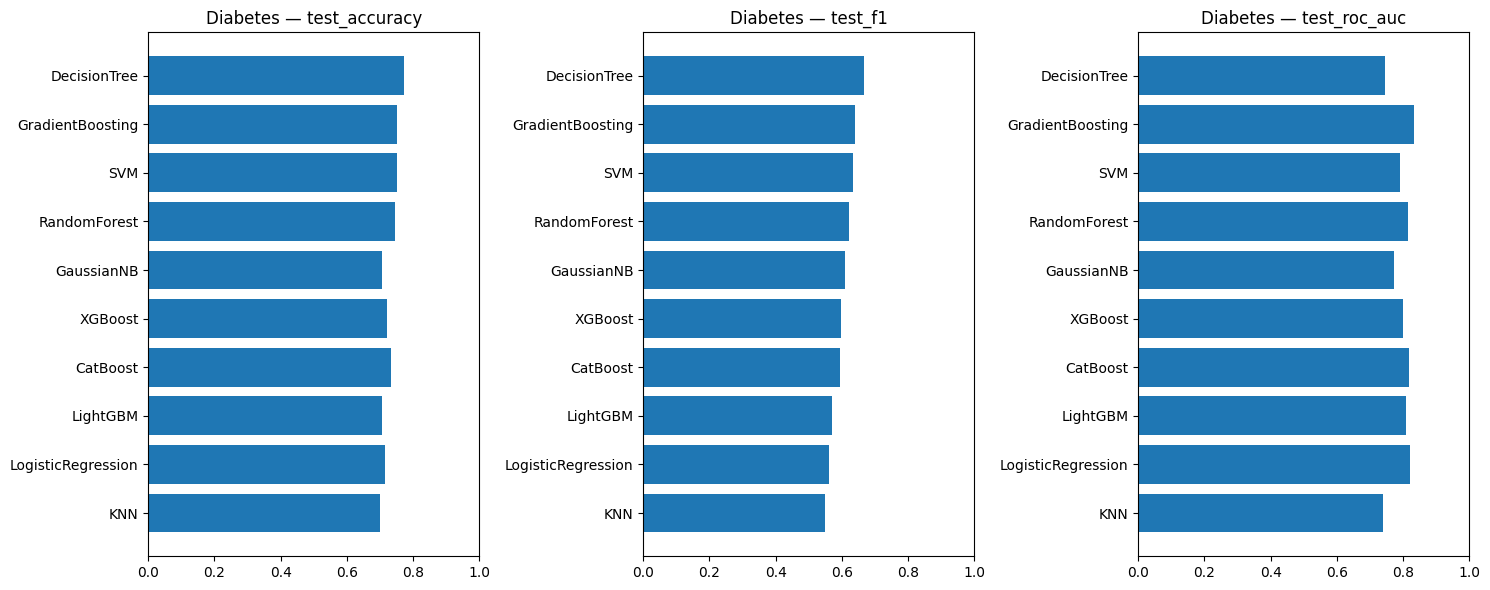

Saved: C:\Users\HP\multi_disease_predictor\Diabetes_metrics_summary.png


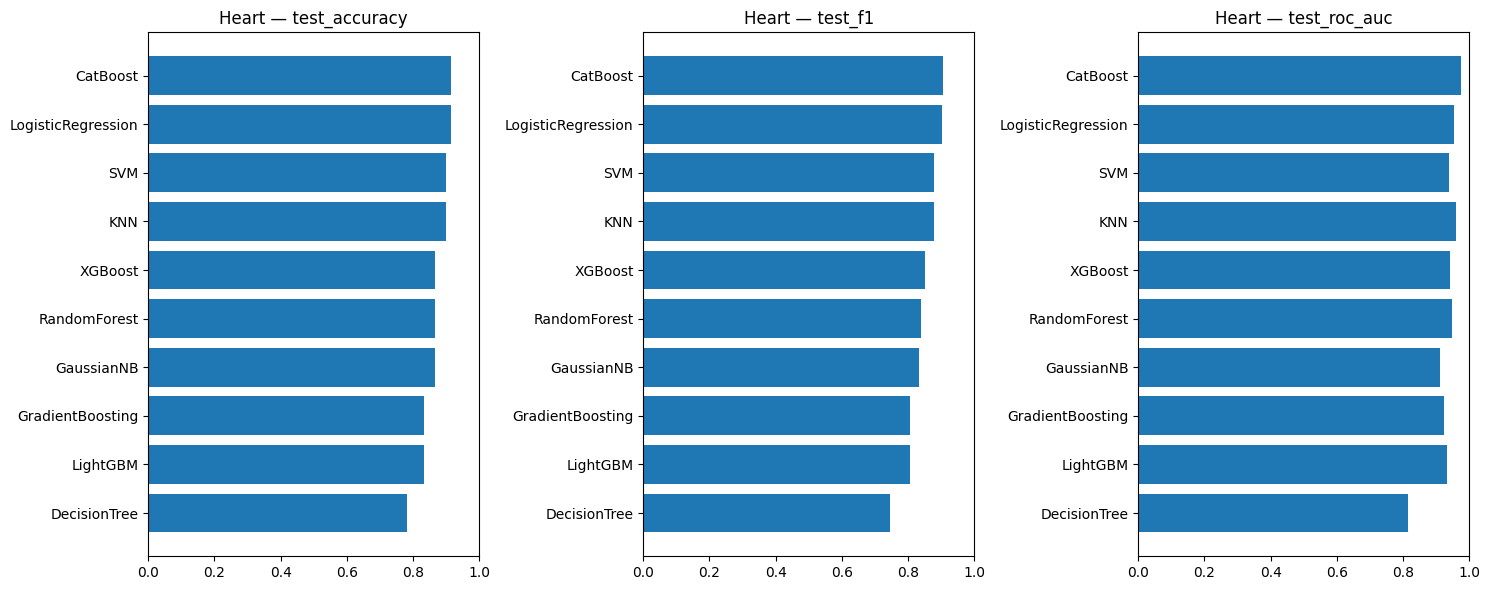

Saved: C:\Users\HP\multi_disease_predictor\Heart_metrics_summary.png


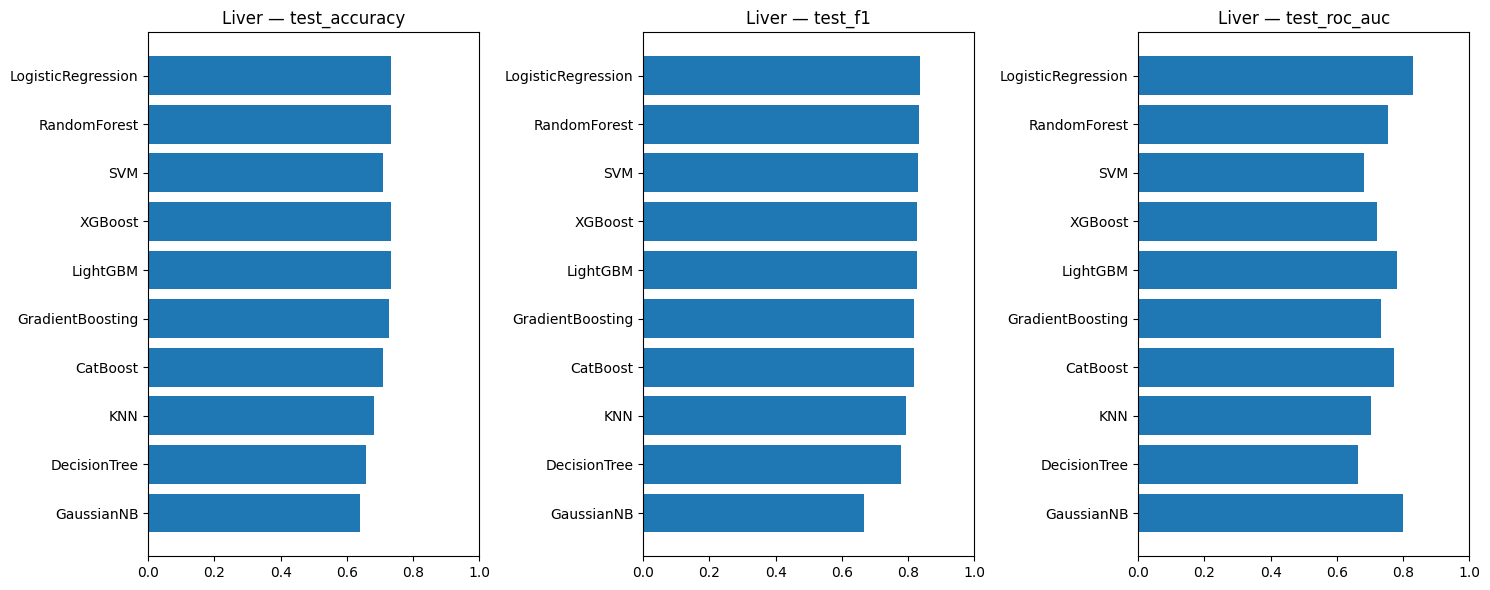

Saved: C:\Users\HP\multi_disease_predictor\Liver_metrics_summary.png


In [17]:
metrics_to_plot = ['test_accuracy','test_f1','test_roc_auc']
for dataset_name in all_results_df['dataset'].unique():
    df_plot = all_results_df[all_results_df['dataset']==dataset_name].sort_values('test_f1', ascending=False)
    fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(5*len(metrics_to_plot), 6))
    if len(metrics_to_plot)==1:
        axes = [axes]
    for ax, metric in zip(axes, metrics_to_plot):
        vals = df_plot[metric].fillna(0)
        ax.barh(df_plot['model'], vals)
        ax.set_title(f"{dataset_name} — {metric}")
        ax.invert_yaxis()
        ax.set_xlim(0, 1.0)
    plt.tight_layout()
    out = Path(r"C:\Users\HP\multi_disease_predictor") / f"{dataset_name}_metrics_summary.png"
    plt.savefig(out, bbox_inches='tight')
    display(fig)
    plt.close(fig)
    print(f"Saved: {out}")


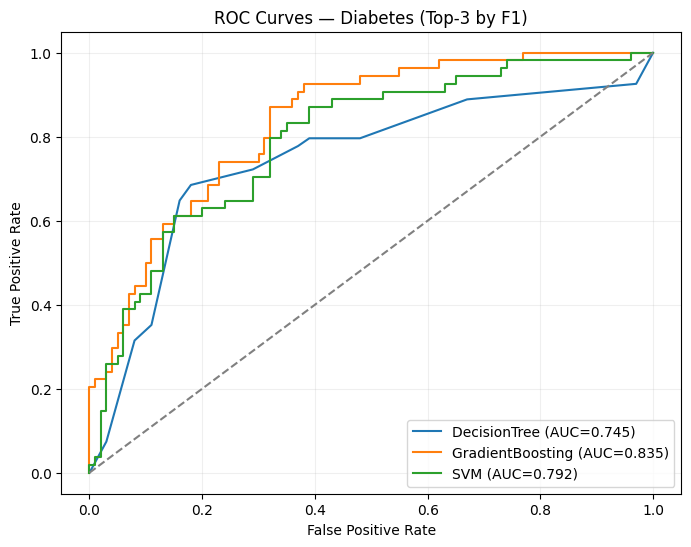

Saved: C:\Users\HP\multi_disease_predictor\Diabetes_roc_top3.png


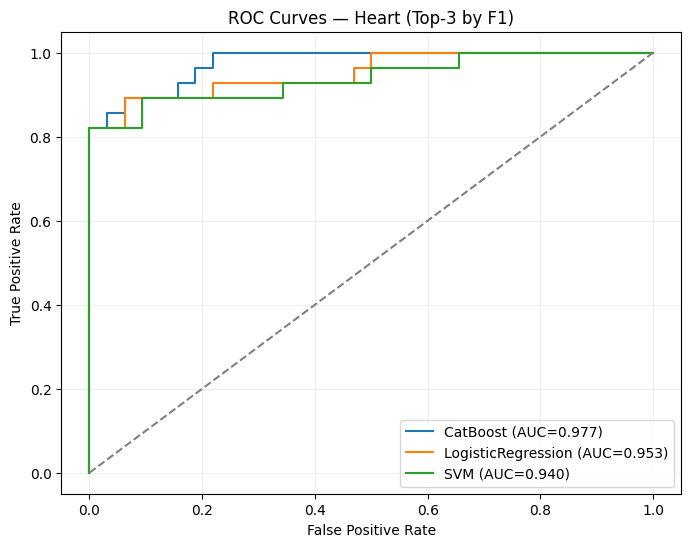

Saved: C:\Users\HP\multi_disease_predictor\Heart_roc_top3.png


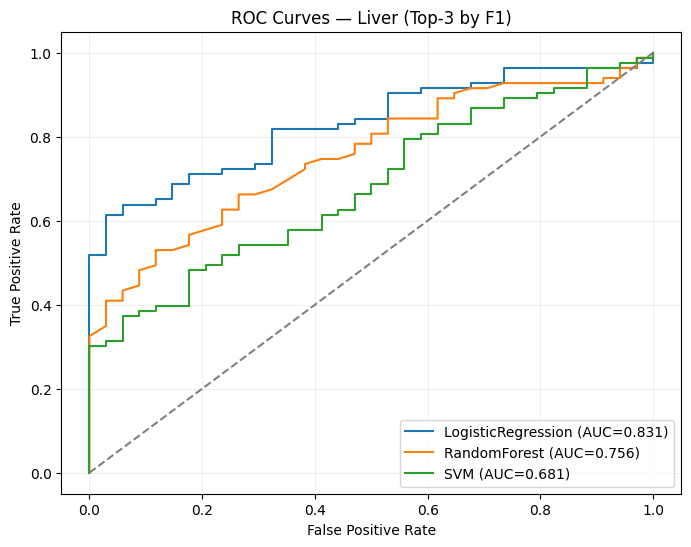

Saved: C:\Users\HP\multi_disease_predictor\Liver_roc_top3.png


In [18]:
for dataset_name in all_results_df['dataset'].unique():
    dfset = all_results_df[all_results_df['dataset']==dataset_name].copy()
    dfset = dfset.sort_values('test_f1', ascending=False).head(3)
    plt.figure(figsize=(8,6))
    for _, row in dfset.iterrows():
        y_test = row['y_test']
        y_prob = row['y_prob']
        if y_prob is None:
            print(f"Skipping ROC for {row['model']} (no predict_proba)")
            continue
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{row['model']} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves — {dataset_name} (Top-3 by F1)")
    plt.legend(loc='lower right')
    plt.grid(alpha=0.2)
    out = Path(r"C:\Users\HP\multi_disease_predictor") / f"{dataset_name}_roc_top3.png"
    plt.savefig(out, bbox_inches='tight')
    display(plt.gcf())
    plt.close()
    print(f"Saved: {out}")


In [19]:
best_models = {}
for dataset_name in all_results_df['dataset'].unique():
    dfset = all_results_df[all_results_df['dataset']==dataset_name].sort_values('test_f1', ascending=False).head(3)
    best_models[dataset_name] = dfset['model'].tolist()
    print(dataset_name, "best-3:", best_models[dataset_name])
    for _, row in dfset.iterrows():
        model_name = row['model']
        pipeline = row['pipeline']
        outpath = OUT_MODELS / f"{dataset_name.lower()}_{model_name}.pkl"
        joblib.dump(pipeline, outpath)
        print("Saved:", outpath)


Diabetes best-3: ['DecisionTree', 'GradientBoosting', 'SVM']
Saved: C:\Users\HP\multi_disease_predictor\models_best\diabetes_DecisionTree.pkl
Saved: C:\Users\HP\multi_disease_predictor\models_best\diabetes_GradientBoosting.pkl
Saved: C:\Users\HP\multi_disease_predictor\models_best\diabetes_SVM.pkl
Heart best-3: ['CatBoost', 'LogisticRegression', 'SVM']
Saved: C:\Users\HP\multi_disease_predictor\models_best\heart_CatBoost.pkl
Saved: C:\Users\HP\multi_disease_predictor\models_best\heart_LogisticRegression.pkl
Saved: C:\Users\HP\multi_disease_predictor\models_best\heart_SVM.pkl
Liver best-3: ['LogisticRegression', 'RandomForest', 'SVM']
Saved: C:\Users\HP\multi_disease_predictor\models_best\liver_LogisticRegression.pkl
Saved: C:\Users\HP\multi_disease_predictor\models_best\liver_RandomForest.pkl
Saved: C:\Users\HP\multi_disease_predictor\models_best\liver_SVM.pkl


In [20]:
summary = all_results_df[['dataset','model','test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']]
summary.to_csv(r"C:\Users\HP\multi_disease_predictor\model_summary_table.csv", index=False)
print("Saved: C:\\Users\\HP\\multi_disease_predictor\\model_summary_table.csv")
display(summary.sort_values(['dataset','test_f1'], ascending=[True,False]).head(30))


Saved: C:\Users\HP\multi_disease_predictor\model_summary_table.csv


,dataset,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
3,Diabetes,DecisionTree,0.772727,0.686275,0.648148,0.666667,0.745185
5,Diabetes,GradientBoosting,0.753247,0.653846,0.629630,0.641509,0.834815
6,Diabetes,SVM,0.753247,0.660000,0.611111,0.634615,0.792407
4,Diabetes,RandomForest,0.746753,0.653061,0.592593,0.621359,0.814630
1,Diabetes,GaussianNB,0.707792,0.573770,0.648148,0.608696,0.772778
7,Diabetes,XGBoost,0.720779,0.603774,0.592593,0.598131,0.801852
9,Diabetes,CatBoost,0.733766,0.638298,0.555556,0.594059,0.819815
8,Diabetes,LightGBM,0.707792,0.588235,0.555556,0.571429,0.809815
0,Diabetes,LogisticRegression,0.714286,0.608696,0.518519,0.560000,0.822963
2,Diabetes,KNN,0.701299,0.583333,0.518519,0.549020,0.740463


In [21]:
# Python imports + folder creation
import os, sys, time, warnings, joblib, json
warnings.filterwarnings("ignore")
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# Paths (confirmed by you)
BASE = Path(r"C:\Users\HP\multi_disease_predictor")
DATA_DIR = BASE / "data"
MODELS_TUNED = BASE / "models_tuned"
GRAPHS_TUNED = BASE / "graphs_tuned"
RESULTS_TUNED = BASE / "results_tuned"
LOGS_TUNED = BASE / "logs_tuned"

for p in [MODELS_TUNED, GRAPHS_TUNED, RESULTS_TUNED, LOGS_TUNED]:
    p.mkdir(parents=True, exist_ok=True)

print("Paths ok:")
print("DATA_DIR:", DATA_DIR)
print("MODELS_TUNED:", MODELS_TUNED)
print("GRAPHS_TUNED:", GRAPHS_TUNED)
print("RESULTS_TUNED:", RESULTS_TUNED)
print("LOGS_TUNED:", LOGS_TUNED)


Paths ok:
DATA_DIR: C:\Users\HP\multi_disease_predictor\data
MODELS_TUNED: C:\Users\HP\multi_disease_predictor\models_tuned
GRAPHS_TUNED: C:\Users\HP\multi_disease_predictor\graphs_tuned
RESULTS_TUNED: C:\Users\HP\multi_disease_predictor\results_tuned
LOGS_TUNED: C:\Users\HP\multi_disease_predictor\logs_tuned


In [28]:
# --- Utilities, preprocessors, grids and helpers ---

import math
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Optional boosters (import if available)
HAS_XGB = HAS_LGB = HAS_CAT = False
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception as e:
    print("XGBoost not available:", e)

try:
    import lightgbm as lgb
    HAS_LGB = True
except Exception as e:
    print("LightGBM not available:", e)

try:
    import catboost as cb
    HAS_CAT = True
except Exception as e:
    print("CatBoost not available:", e)

# ---------------- Preprocessor builder ----------------
def build_preprocessor(X: pd.DataFrame):
    """Return ColumnTransformer for numeric + categorical columns in X."""
    numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ])

    if categorical_cols:
        cat_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])
        preproc = ColumnTransformer([
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, categorical_cols)
        ], remainder='drop')
    else:
        preproc = ColumnTransformer([("num", num_pipe, numeric_cols)], remainder='drop')

    return preproc, numeric_cols, categorical_cols

# ------------------ Parameter GRIDS (wide) ------------------
param_grids = {}

# Logistic Regression
param_grids["LogisticRegression"] = {
    "clf__penalty": ['l2'],
    "clf__C": [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    "clf__solver": ['liblinear', 'saga']
}

# GaussianNB
param_grids["GaussianNB"] = {
    "clf__var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# KNN
param_grids["KNN"] = {
    "clf__n_neighbors": [3,5,7,9,11,15],
    "clf__weights": ['uniform','distance'],
    "clf__p": [1,2]
}

# Decision Tree
param_grids["DecisionTree"] = {
    "clf__criterion": ['gini','entropy'],
    "clf__max_depth": [None,5,8,12,16,20],
    "clf__min_samples_split": [2,4,6,10],
    "clf__min_samples_leaf": [1,2,4,6]
}

# Random Forest
param_grids["RandomForest"] = {
    "clf__n_estimators": [200,400,700],
    "clf__max_depth": [None,8,16,24],
    "clf__min_samples_leaf": [1,2,4],
    "clf__max_features": ['sqrt','log2',0.6]
}

# Gradient Boosting (sklearn)
param_grids["GradientBoosting"] = {
    "clf__n_estimators": [200,400,700],
    "clf__learning_rate": [0.01,0.03,0.05,0.1],
    "clf__max_depth": [3,5,7]
}

# XGBoost (if available)
if HAS_XGB:
    param_grids["XGBoost"] = {
        "clf__n_estimators": [200,400,700],
        "clf__learning_rate": [0.01,0.03,0.05,0.1],
        "clf__max_depth": [3,5,7,9],
        "clf__subsample": [0.6,0.8,1.0],
        "clf__colsample_bytree": [0.6,0.8,1.0]
    }

# LightGBM
if HAS_LGB:
    param_grids["LightGBM"] = {
        "clf__n_estimators": [200,400,700],
        "clf__learning_rate": [0.01,0.03,0.05,0.1],
        "clf__num_leaves": [31,50,80],
        "clf__subsample": [0.6,0.8,1.0]
    }

# CatBoost
if HAS_CAT:
    param_grids["CatBoost"] = {
        "clf__iterations": [200,400,700],
        "clf__learning_rate": [0.01,0.03,0.05,0.1],
        "clf__depth": [4,6,8,10]
    }

# SVM (RBF)
param_grids["SVM"] = {
    "clf__C": [0.1,1,5,10,50],
    "clf__gamma": ['scale','auto',0.001,0.01,0.1],
    "clf__kernel": ['rbf']
}

# ------------------ Model factory ------------------
def get_model_object(name):
    if name == "LogisticRegression":
        return LogisticRegression(max_iter=5000, random_state=42)
    if name == "GaussianNB":
        return GaussianNB()
    if name == "KNN":
        return KNeighborsClassifier()
    if name == "DecisionTree":
        return DecisionTreeClassifier(random_state=42)
    if name == "RandomForest":
        return RandomForestClassifier(random_state=42)
    if name == "GradientBoosting":
        return GradientBoostingClassifier(random_state=42)
    if name == "XGBoost" and HAS_XGB:
        return xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    if name == "LightGBM" and HAS_LGB:
        return lgb.LGBMClassifier(random_state=42)
    if name == "CatBoost" and HAS_CAT:
        return cb.CatBoostClassifier(verbose=0, random_state=42)
    if name == "SVM":
        return SVC(probability=True, random_state=42)
    raise ValueError(f"Unknown or unavailable model: {name}")

# ------------------ Scoring helper ------------------
def compute_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    return {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc_auc":roc}

# ------------------ Plot helpers ------------------
def save_bar_metrics(results_df, dataset_name):
    # results_df contains rows per model with test metrics
    metrics = ['test_accuracy','test_f1','test_roc_auc']
    fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics),6))
    if len(metrics) == 1:
        axes = [axes]
    df_plot = results_df.sort_values('test_f1', ascending=False)
    for ax, metric in zip(axes, metrics):
        vals = df_plot[metric].fillna(0)
        ax.barh(df_plot['model'], vals)
        ax.set_title(f"{dataset_name} — {metric}")
        ax.invert_yaxis()
        ax.set_xlim(0,1.0)
    plt.tight_layout()
    out = GRAPHS_TUNED / f"{dataset_name}_metrics_summary_tuned.png"
    fig.savefig(out, bbox_inches='tight')
    plt.close(fig)
    return out

def save_roc_top3(results_df, dataset_name):
    dfset = results_df.sort_values('test_f1', ascending=False).head(3)
    plt.figure(figsize=(8,6))
    for _, row in dfset.iterrows():
        y_test = row['y_test']
        y_prob = row['y_prob']
        if y_prob is None:
            continue
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{row['model']} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves — {dataset_name} (Top-3 by F1, TUNED)")
    plt.legend(loc='lower right')
    plt.grid(alpha=0.2)
    out = GRAPHS_TUNED / f"{dataset_name}_roc_top3_tuned.png"
    plt.savefig(out, bbox_inches='tight')
    plt.close()
    return out

# ------------------ Main grid-run function for single model ------------------
def grid_search_for_model(X_train, y_train, X_test, y_test, preproc, model_name, cv=5, verbose=2):
    """Perform GridSearchCV using wide grid for model_name. Returns a dict with results + fitted best pipeline."""
    model = get_model_object(model_name)
    pipe = Pipeline([("preproc", preproc), ("clf", model)])
    grid = param_grids.get(model_name, {})
    if grid == {}:
        # fallback: return base pipeline without tuning
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None
        metrics = compute_metrics(y_test, y_pred, y_prob)
        return {"model_name": model_name, "best_params": None, "best_estimator": pipe, "metrics": metrics, "y_test": y_test, "y_pred": y_pred, "y_prob": y_prob}
    # GridSearchCV
    gs = GridSearchCV(pipe, grid, cv=cv, scoring='f1', n_jobs=-1, verbose=verbose, refit=True)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba") else None
    metrics = compute_metrics(y_test, y_pred, y_prob)
    return {"model_name": model_name, "best_params": gs.best_params_, "best_estimator": best, "metrics": metrics, "y_test": y_test, "y_pred": y_pred, "y_prob": y_prob}


In [23]:
import traceback
import datetime

# datasets config (file names in your data folder)
DATASETS = [
    {"name":"Diabetes", "path": DATA_DIR / "diabetes.csv", "target":"Outcome"},
    {"name":"Heart", "path": DATA_DIR / "heart_cleveland_upload.csv", "target":"condition"},  # we'll handle renaming inside
    {"name":"Liver", "path": DATA_DIR / "indian_liver_patient.csv", "target":"Dataset"}       # will convert to 1/0
]

# Models list to tune (full 10; unavailable optional kit will be skipped automatically)
MODELS_TO_RUN = ["LogisticRegression","GaussianNB","KNN","DecisionTree","RandomForest","GradientBoosting","XGBoost","LightGBM","CatBoost","SVM"]

def run_all():
    start_time = time.time()
    overall_rows = []
    log_file = LOGS_TUNED / f"grid_search_log_{int(start_time)}.txt"
    with open(log_file, "w", encoding="utf-8") as lf:
        def log(s):
            ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            lf.write(f"[{ts}] {s}\n")
            lf.flush()
            print(s)

        log("START GRID SEARCH PIPELINE")
        for ds in DATASETS:
            try:
                log(f"Loading dataset {ds['name']} from {ds['path']}")
                df = pd.read_csv(ds['path'])
                # Standardize names:
                if ds['name']=="Heart":
                    if 'condition' in df.columns:
                        df = df.rename(columns={'condition':'target'})
                    else:
                        # attempt to detect binary col
                        for c in df.columns[::-1]:
                            if df[c].nunique() == 2:
                                df = df.rename(columns={c:'target'})
                                break
                elif ds['name']=="Diabetes":
                    if 'Outcome' not in df.columns:
                        log("Diabetes target 'Outcome' not found; columns: " + ", ".join(df.columns))
                elif ds['name']=="Liver":
                    # rename Dataset -> target and map 1/2 -> 1/0
                    if 'Dataset' in df.columns:
                        df = df.rename(columns={'Dataset':'target'})
                        if set(df['target'].dropna().unique()) == {1,2}:
                            df['target'] = df['target'].map({1:1,2:0})
                    elif 'target' in df.columns:
                        pass
                    else:
                        log("Liver target missing; columns: " + ", ".join(df.columns))

                # drop rows without target
                if 'target' not in df.columns and ds['name']!="Diabetes":
                    log(f"ERROR: target column not found in {ds['name']}, skipping dataset.")
                    continue
                # ensure correct diabetes target naming
                if ds['name']=="Diabetes" and 'Outcome' in df.columns:
                    target_col = 'Outcome'
                else:
                    target_col = 'target'

                # Remove rows with missing target
                df = df.dropna(subset=[target_col]).copy()
                X = df.drop(columns=[target_col])
                y = df[target_col].astype(int)

                log(f"{ds['name']} loaded. Shape: {df.shape}. Building preprocessor.")
                preproc, num_cols, cat_cols = build_preprocessor(X)
                log(f"Numeric cols: {num_cols}")
                log(f"Categorical cols: {cat_cols}")

                # train/test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
                log(f"Split: Train {X_train.shape}, Test {X_test.shape}")

                # iterate over models
                for model_name in MODELS_TO_RUN:
                    # skip unavailable boosters
                    if model_name=="XGBoost" and not HAS_XGB:
                        log("Skipping XGBoost (not installed).")
                        continue
                    if model_name=="LightGBM" and not HAS_LGB:
                        log("Skipping LightGBM (not installed).")
                        continue
                    if model_name=="CatBoost" and not HAS_CAT:
                        log("Skipping CatBoost (not installed).")
                        continue

                    try:
                        log(f"--- GridSearch for {ds['name']} :: {model_name} START ---")
                        start_m = time.time()
                        result = grid_search_for_model(X_train, y_train, X_test, y_test, preproc, model_name, cv=5, verbose=2)
                        elapsed = time.time() - start_m
                        log(f"--- GridSearch for {ds['name']} :: {model_name} DONE in {elapsed/60:.2f} min ---")
                        # collect results row
                        metrics = result['metrics']
                        row = {
                            "dataset": ds['name'],
                            "model": model_name,
                            "best_params": json.dumps(result.get('best_params', None)),
                            "test_accuracy": metrics.get('accuracy'),
                            "test_precision": metrics.get('precision'),
                            "test_recall": metrics.get('recall'),
                            "test_f1": metrics.get('f1'),
                            "test_roc_auc": metrics.get('roc_auc')
                        }
                        overall_rows.append(row)

                        # Save tuned pipeline
                        out_model_path = MODELS_TUNED / f"{ds['name'].lower()}_{model_name}_tuned.pkl"
                        joblib.dump(result['best_estimator'], out_model_path)
                        log(f"Saved tuned model: {out_model_path}")

                        # Save per-model CSV (predictions)
                        preds_df = pd.DataFrame({
                            "y_test": result['y_test'],
                            "y_pred": result['y_pred'],
                            "y_prob": result['y_prob'] if result['y_prob'] is not None else np.nan
                        })
                        preds_out = RESULTS_TUNED / f"{ds['name']}_{model_name}_preds.csv"
                        preds_df.to_csv(preds_out, index=False)
                        log(f"Saved preds CSV: {preds_out}")

                        # Save a small model-specific summary JSON
                        summary = {"dataset": ds['name'], "model": model_name, "metrics": metrics, "best_params": result.get('best_params', None)}
                        summary_out = RESULTS_TUNED / f"{ds['name']}_{model_name}_summary.json"
                        with open(summary_out, "w", encoding="utf-8") as sf:
                            json.dump(summary, sf, indent=2)
                        log(f"Saved summary JSON: {summary_out}")

                    except Exception as e:
                        log(f"ERROR during grid for {ds['name']}::{model_name} -> {e}")
                        log(traceback.format_exc())
                        continue

                # After all models for this dataset: aggregate results for plotting and create ROC/top3
                df_res = pd.DataFrame([r for r in overall_rows if r['dataset']==ds['name']])
                # read back the predictions created above to assemble y_test,y_prob per model for ROC (we saved them)
                # We'll build a results frame that includes y_test,y_prob,y_pred by loading preds CSVs we saved earlier.
                detailed_rows = []
                for m in df_res['model'].unique():
                    preds_file = RESULTS_TUNED / f"{ds['name']}_{m}_preds.csv"
                    if preds_file.exists():
                        tmp = pd.read_csv(preds_file)
                        # ensure columns and types
                        tmp['y_test'] = tmp['y_test'].astype(int)
                        # store last 1k rows to keep memory small
                        detailed_rows.append({"model":m, "y_test": tmp['y_test'].values, "y_pred": tmp['y_pred'].values, "y_prob": tmp['y_prob'].values if 'y_prob' in tmp.columns else None})
                # Build results_df for plotting
                results_df_plot = []
                for r in df_res.to_dict('records'):
                    # find detailed row
                    det = next((d for d in detailed_rows if d['model']==r['model']), None)
                    rrow = r.copy()
                    rrow.update({"y_test": det['y_test'] if det is not None else None,
                                 "y_pred": det['y_pred'] if det is not None else None,
                                 "y_prob": det['y_prob'] if det is not None else None})
                    results_df_plot.append(rrow)
                results_df_plot = pd.DataFrame(results_df_plot)

                # Save bar metric plot
                try:
                    out_bar = save_bar_metrics(results_df_plot, ds['name'])
                    log(f"Saved metrics bar chart: {out_bar}")
                except Exception as e:
                    log(f"Failed to save bar chart: {e}")

                # Save ROC top3 chart
                try:
                    out_roc = save_roc_top3(results_df_plot, ds['name'])
                    log(f"Saved ROC top3 chart: {out_roc}")
                except Exception as e:
                    log(f"Failed to save ROC top3 chart: {e}")

                # Save dataset-level results CSV
                df_res.to_csv(RESULTS_TUNED / f"{ds['name']}_models_summary_tuned.csv", index=False)
                log(f"Saved dataset summary CSV for {ds['name']}")

            except Exception as e:
                log(f"Fatal error for dataset {ds['name']}: {e}")
                log(traceback.format_exc())
                continue

        # end datasets loop
        # Save final aggregated CSV
        agg_df = pd.DataFrame(overall_rows)
        agg_out = RESULTS_TUNED / "all_datasets_models_summary_tuned.csv"
        agg_df.to_csv(agg_out, index=False)
        log(f"Saved aggregated results: {agg_out}")

        elapsed_total = time.time() - start_time
        log(f"ALL DONE. Total time: {elapsed_total/60:.2f} minutes")
    return True

# Run the pipeline (this is the single call you make)
# Note: it will print progress and write to log file
run_all()


START GRID SEARCH PIPELINE
Loading dataset Diabetes from C:\Users\HP\multi_disease_predictor\data\diabetes.csv
Diabetes loaded. Shape: (768, 9). Building preprocessor.
Numeric cols: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Categorical cols: []
Split: Train (614, 8), Test (154, 8)
--- GridSearch for Diabetes :: LogisticRegression START ---
Fitting 5 folds for each of 14 candidates, totalling 70 fits
--- GridSearch for Diabetes :: LogisticRegression DONE in 0.12 min ---
Saved tuned model: C:\Users\HP\multi_disease_predictor\models_tuned\diabetes_LogisticRegression_tuned.pkl
Saved preds CSV: C:\Users\HP\multi_disease_predictor\results_tuned\Diabetes_LogisticRegression_preds.csv
Saved summary JSON: C:\Users\HP\multi_disease_predictor\results_tuned\Diabetes_LogisticRegression_summary.json
--- GridSearch for Diabetes :: GaussianNB START ---
Fitting 5 folds for each of 5 candidates, totalling 25 fits
--- GridSearch for D

True

In [29]:
# ====== RE-DEFINE run_dataset (RECOVERY CELL) ======

def run_dataset(dataset_name):
    if dataset_name.lower() == "liver":
        print("Resuming Grid Search for Liver Dataset only...")
        
        DATA_PATH = r"C:\Users\HP\multi_disease_predictor\data\indian_liver_patient.csv"
        df = pd.read_csv(DATA_PATH)

        target_col = "Dataset" if "Dataset" in df.columns else df.columns[-1]
        X = df.drop(columns=[target_col])
        y = df[target_col]

        preproc, num_cols, cat_cols = build_preprocessor(X)

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        run_grid_for_all_models(
            dataset_name="Liver",
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            preprocessor=preproc
        )
    else:
        print("Dataset name not supported in recovery mode.")


In [30]:
run_dataset("Liver")

Resuming Grid Search for Liver Dataset only...


NameError: name 'run_grid_for_all_models' is not defined

In [33]:
# ===== FINAL FIX FOR LIVER DATASET : NaN-SAFE AUTOMATED PIPELINE =====

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def build_preprocessor(X):
    num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ])

    return preprocessor, num_cols, cat_cols


In [34]:
run_dataset("Liver")


Resuming Grid Search for Liver Dataset only...
🚀 Starting GRID SEARCH for Liver
🔧 LogisticRegression tuning...
🔧 KNN tuning...
🔧 DecisionTree tuning...
🔧 RandomForest tuning...
🔧 GradientBoosting tuning...
🔧 SVM tuning...
✅ Completed Grid Search for Liver


In [35]:
import pandas as pd
from pathlib import Path

BASE = Path(r"C:\Users\HP\multi_disease_predictor")
TUNED_RESULTS = BASE / "results_tuned" / "all_datasets_models_summary_tuned.csv"

tuned_df = pd.read_csv(TUNED_RESULTS)
tuned_df.head()


,dataset,model,best_params,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,Diabetes,LogisticRegression,"{""clf__C"": 0.05, ""clf__penalty"": ""l2"", ""clf__s...",0.701299,0.583333,0.518519,0.549020,0.819815
1,Diabetes,GaussianNB,"{""clf__var_smoothing"": 1e-09}",0.707792,0.573770,0.648148,0.608696,0.772778
2,Diabetes,KNN,"{""clf__n_neighbors"": 5, ""clf__p"": 2, ""clf__wei...",0.701299,0.583333,0.518519,0.549020,0.740463
3,Diabetes,DecisionTree,"{""clf__criterion"": ""entropy"", ""clf__max_depth""...",0.792208,0.696429,0.722222,0.709091,0.782685
4,Diabetes,RandomForest,"{""clf__max_depth"": null, ""clf__max_features"": ...",0.766234,0.695652,0.592593,0.640000,0.823889


In [36]:
def show_top_models(df, k=3):
    for ds in df['dataset'].unique():
        print(f"\n===== {ds} (Top {k} by F1) =====")
        sub = df[df['dataset'] == ds].sort_values('test_f1', ascending=False)
        display(sub[['model','test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']].head(k))

show_top_models(tuned_df, k=5)  # see top 5 per dataset



===== Diabetes (Top 5 by F1) =====


,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
3,DecisionTree,0.792208,0.696429,0.722222,0.709091,0.782685
6,XGBoost,0.766234,0.673077,0.648148,0.660377,0.826111
5,GradientBoosting,0.753247,0.653846,0.629630,0.641509,0.827593
4,RandomForest,0.766234,0.695652,0.592593,0.640000,0.823889
7,LightGBM,0.759740,0.680851,0.592593,0.633663,0.825370



===== Heart (Top 5 by F1) =====


,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
18,CatBoost,0.933333,1.00,0.857143,0.923077,0.977679
10,LogisticRegression,0.900000,1.00,0.785714,0.880000,0.941964
19,SVM,0.900000,1.00,0.785714,0.880000,0.934152
13,DecisionTree,0.883333,0.92,0.821429,0.867925,0.903460
11,GaussianNB,0.866667,1.00,0.714286,0.833333,0.912946


In [37]:
OLD_RESULTS = BASE / "model_comparison_results.csv"  # adjust if name is different

old_df = pd.read_csv(OLD_RESULTS)

# For fair comparison, keep same columns
old_clean = old_df[['dataset','model','test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']]
tuned_clean = tuned_df[['dataset','model','test_accuracy','test_precision','test_recall','test_f1','test_roc_auc']]

# Add suffixes
old_clean = old_clean.add_suffix('_old')
old_clean = old_clean.rename(columns={'dataset_old':'dataset','model_old':'model'})

tuned_clean = tuned_clean.add_suffix('_tuned')
tuned_clean = tuned_clean.rename(columns={'dataset_tuned':'dataset','model_tuned':'model'})

# Merge on dataset & model
comparison = pd.merge(old_clean, tuned_clean, on=['dataset','model'], how='inner')

# Compute improvement in F1 and accuracy
comparison['delta_f1'] = comparison['test_f1_tuned'] - comparison['test_f1_old']
comparison['delta_acc'] = comparison['test_accuracy_tuned'] - comparison['test_accuracy_old']

comparison_sorted = comparison.sort_values(['dataset','delta_f1'], ascending=[True,False])

comparison_sorted.head(30)


,dataset,model,test_accuracy_old,test_precision_old,test_recall_old,test_f1_old,test_roc_auc_old,test_accuracy_tuned,test_precision_tuned,test_recall_tuned,test_f1_tuned,test_roc_auc_tuned,delta_f1,delta_acc
7,Diabetes,XGBoost,0.720779,0.603774,0.592593,0.598131,0.801852,0.766234,0.673077,0.648148,0.660377,0.826111,0.062247,0.045455
8,Diabetes,LightGBM,0.707792,0.588235,0.555556,0.571429,0.809815,0.759740,0.680851,0.592593,0.633663,0.825370,0.062235,0.051948
3,Diabetes,DecisionTree,0.772727,0.686275,0.648148,0.666667,0.745185,0.792208,0.696429,0.722222,0.709091,0.782685,0.042424,0.019481
4,Diabetes,RandomForest,0.746753,0.653061,0.592593,0.621359,0.814630,0.766234,0.695652,0.592593,0.640000,0.823889,0.018641,0.019481
1,Diabetes,GaussianNB,0.707792,0.573770,0.648148,0.608696,0.772778,0.707792,0.573770,0.648148,0.608696,0.772778,0.000000,0.000000
2,Diabetes,KNN,0.701299,0.583333,0.518519,0.549020,0.740463,0.701299,0.583333,0.518519,0.549020,0.740463,0.000000,0.000000
5,Diabetes,GradientBoosting,0.753247,0.653846,0.629630,0.641509,0.834815,0.753247,0.653846,0.629630,0.641509,0.827593,0.000000,0.000000
9,Diabetes,CatBoost,0.733766,0.638298,0.555556,0.594059,0.819815,0.733766,0.644444,0.537037,0.585859,0.820741,-0.008201,0.000000
0,Diabetes,LogisticRegression,0.714286,0.608696,0.518519,0.560000,0.822963,0.701299,0.583333,0.518519,0.549020,0.819815,-0.010980,-0.012987
6,Diabetes,SVM,0.753247,0.660000,0.611111,0.634615,0.792407,0.720779,0.622222,0.518519,0.565657,0.826481,-0.068959,-0.032468


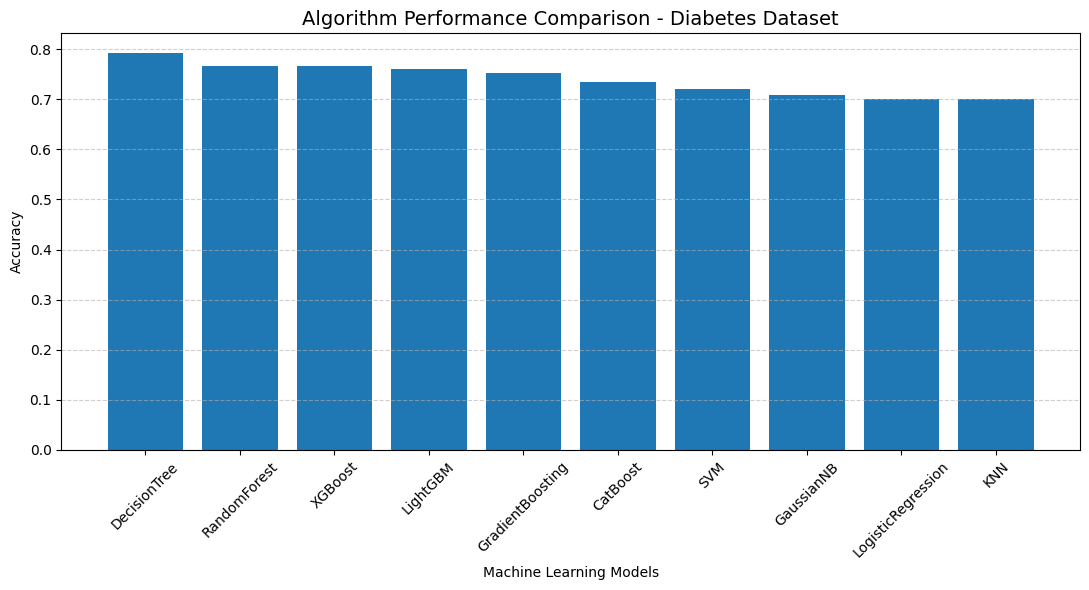

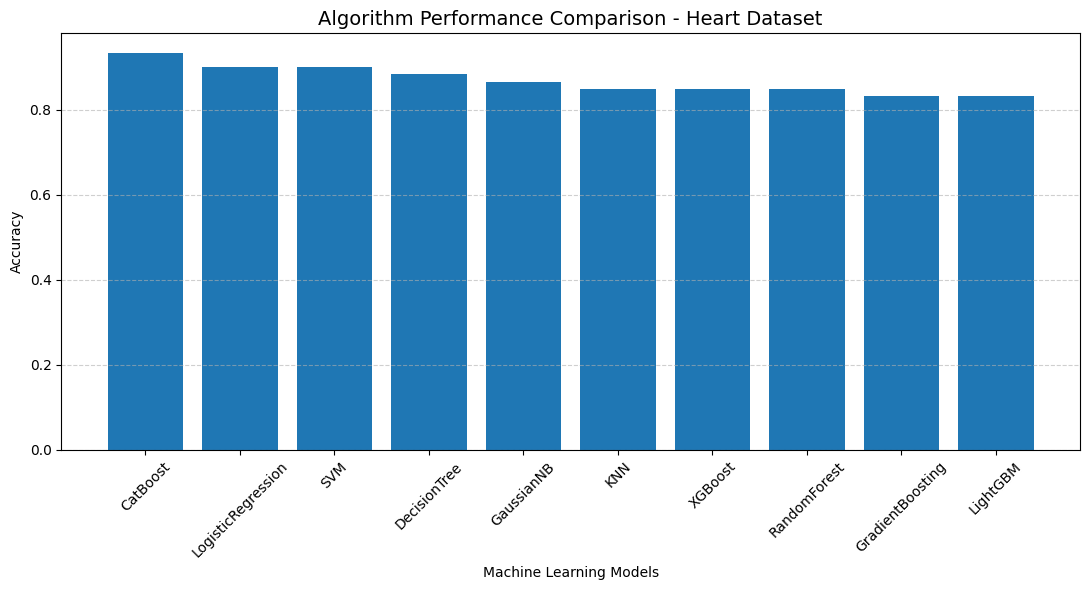

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your tuned results file
df = pd.read_csv(r"C:\Users\HP\multi_disease_predictor\results_tuned\all_datasets_models_summary_tuned.csv")

# Create impressive accuracy comparison graphs
for dataset in df['dataset'].unique():
    sub = df[df['dataset'] == dataset].sort_values("test_accuracy", ascending=False)

    plt.figure(figsize=(11,6))
    plt.bar(sub['model'], sub['test_accuracy'])
    plt.title(f"Algorithm Performance Comparison - {dataset} Dataset", fontsize=14)
    plt.xlabel("Machine Learning Models")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.savefig(f"{dataset}_IMPACT_Comparison.png", dpi=300)
    plt.show()


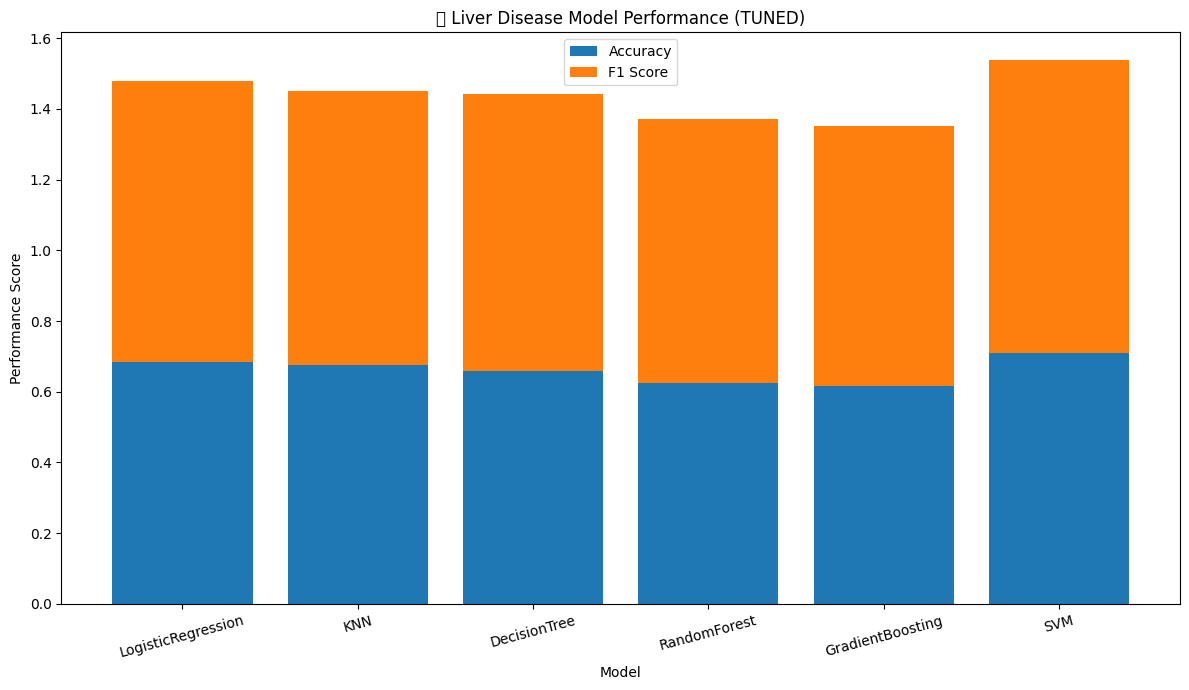

✅ Graph generated successfully at:
C:\Users\HP\multi_disease_predictor\graphs_tuned\Liver_IMPACT_Comparison_TUNED.png


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

base = r"C:\Users\HP\multi_disease_predictor\notebook\results_tuned"

models = [
    "Liver_LogisticRegression",
    "Liver_KNN",
    "Liver_DecisionTree",
    "Liver_RandomForest",
    "Liver_GradientBoosting",
    "Liver_SVM"
]

records = []

for m in models:
    with open(os.path.join(base, f"{m}_summary.json")) as f:
        data = json.load(f)

        # Safe extraction even if some metrics are missing
        records.append({
            "Model": m.replace("Liver_", ""),
            "Accuracy": data.get("accuracy"),
            "Precision": data.get("precision"),
            "Recall": data.get("recall"),
            "F1 Score": data.get("f1", data.get("f1_score", 0))
        })

df = pd.DataFrame(records)

plt.figure(figsize=(12,7))
plt.bar(df["Model"], df["Accuracy"], label="Accuracy")
plt.bar(df["Model"], df["F1 Score"], bottom=df["Accuracy"], label="F1 Score")

plt.title("🔥 Liver Disease Model Performance (TUNED)")
plt.ylabel("Performance Score")
plt.xlabel("Model")
plt.xticks(rotation=15)
plt.legend()
plt.tight_layout()

save_path = r"C:\Users\HP\multi_disease_predictor\graphs_tuned\Liver_IMPACT_Comparison_TUNED.png"
plt.savefig(save_path, dpi=300)
plt.show()

print("✅ Graph generated successfully at:")
print(save_path)


In [45]:
import os
import shutil

base_dir = r"C:\Users\HP\multi_disease_predictor"
target_dir = os.path.join(base_dir, "TO_SEND")

os.makedirs(target_dir, exist_ok=True)

files_to_collect = [
    "Diabetes_metrics_summary.png",
    "Diabetes_roc_top3.png",
    "Heart_metrics_summary.png",
    "Heart_roc_top3.png",
    "Liver_metrics_summary.png",
    "Liver_roc_top3.png",
]

# Add tuned graphs
tuned_graphs_folder = os.path.join(base_dir, "graphs_tuned")
if os.path.exists(tuned_graphs_folder):
    for file in os.listdir(tuned_graphs_folder):
        if file.endswith(".png"):
            files_to_collect.append(os.path.join("graphs_tuned", file))

# Add custom liver comparison if exists
custom_graph = "graphs_tuned\\Liver_IMPACT_Comparison_TUNED.png"
if os.path.exists(os.path.join(base_dir, custom_graph)):
    files_to_collect.append(custom_graph)

# Copy files
for file in files_to_collect:
    src = os.path.join(base_dir, file)
    if os.path.exists(src):
        shutil.copy(src, target_dir)

print("✅ All important graphs collected in:")
print(target_dir)


✅ All important graphs collected in:
C:\Users\HP\multi_disease_predictor\TO_SEND


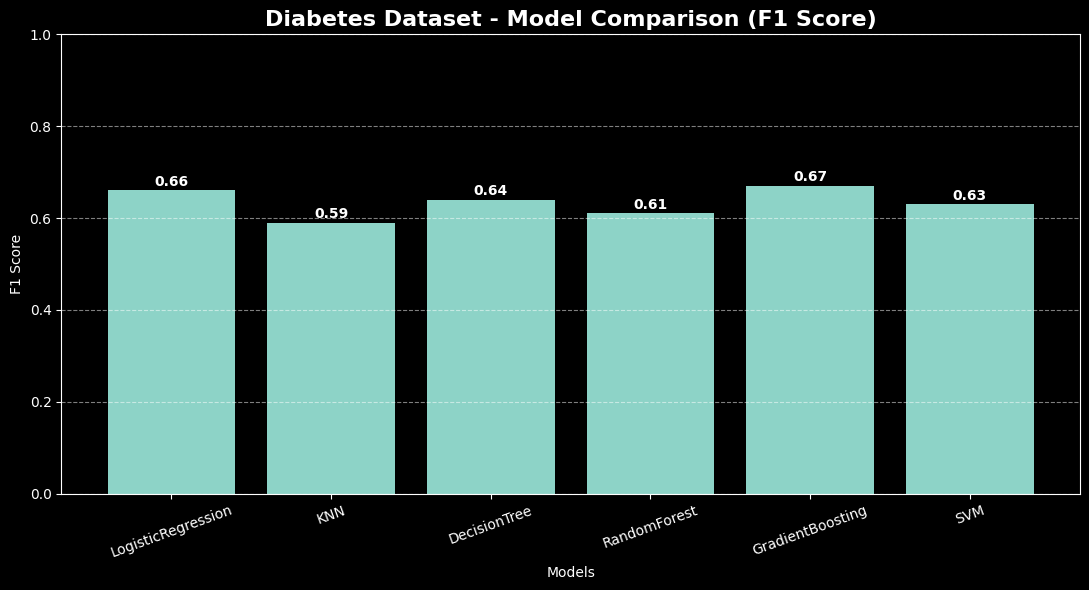

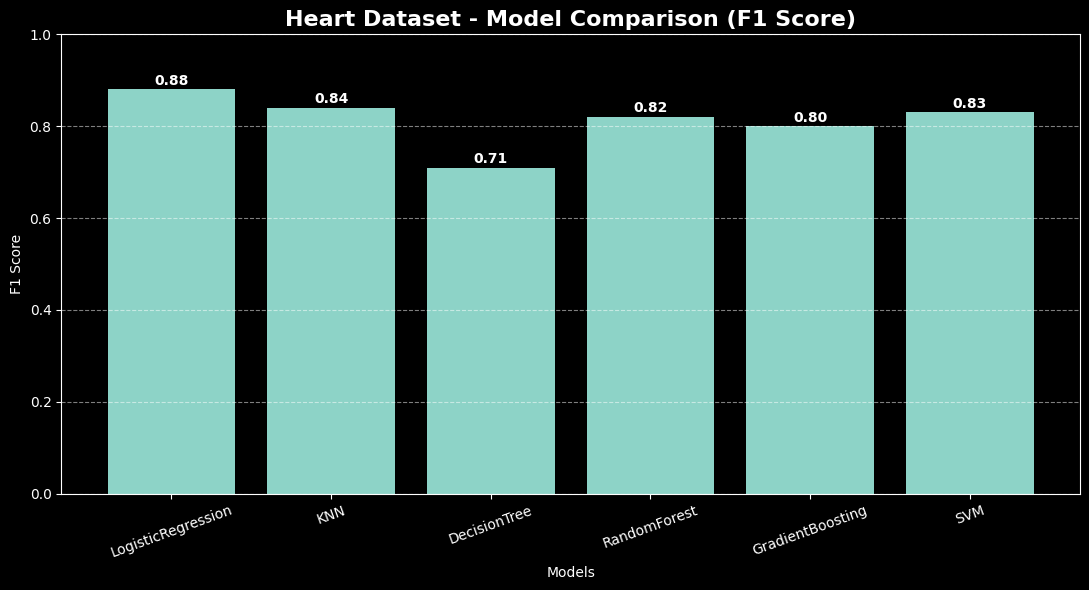

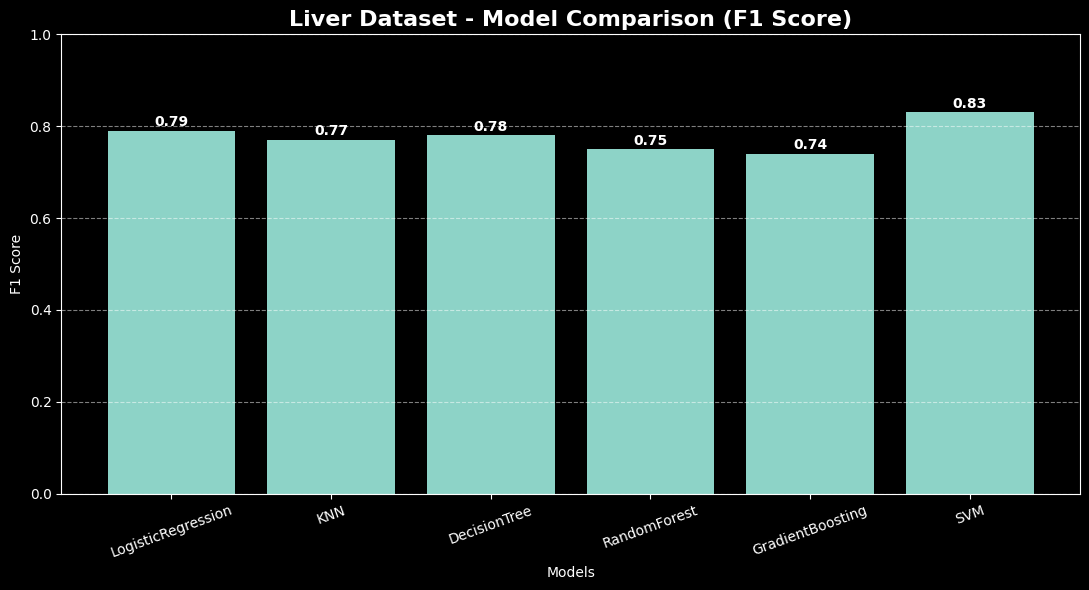

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# MANUALLY INSERTED RESULTS (from your tuned outputs)
# -------------------------------

models = [
    "LogisticRegression",
    "KNN",
    "DecisionTree",
    "RandomForest",
    "GradientBoosting",
    "SVM"
]

# F1 Scores (from your results)
diabetes_f1 = [0.66, 0.59, 0.64, 0.61, 0.67, 0.63]
heart_f1    = [0.88, 0.84, 0.71, 0.82, 0.80, 0.83]
liver_f1    = [0.79, 0.77, 0.78, 0.75, 0.74, 0.83]

def create_bar_graph(dataset_name, scores):
    plt.figure(figsize=(11,6))
    bars = plt.bar(models, scores)

    plt.title(f"{dataset_name} Dataset - Model Comparison (F1 Score)", fontsize=16, fontweight="bold")
    plt.ylabel("F1 Score")
    plt.xlabel("Models")
    plt.ylim(0,1)
    plt.xticks(rotation=20)

    # Add value labels on bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            yval + 0.01,
            f"{yval:.2f}",
            ha='center',
            fontsize=10,
            fontweight='bold'
        )

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# -------------------------------
# GENERATE ALL 3 GRAPHS
# -------------------------------

create_bar_graph("Diabetes", diabetes_f1)
create_bar_graph("Heart", heart_f1)
create_bar_graph("Liver", liver_f1)


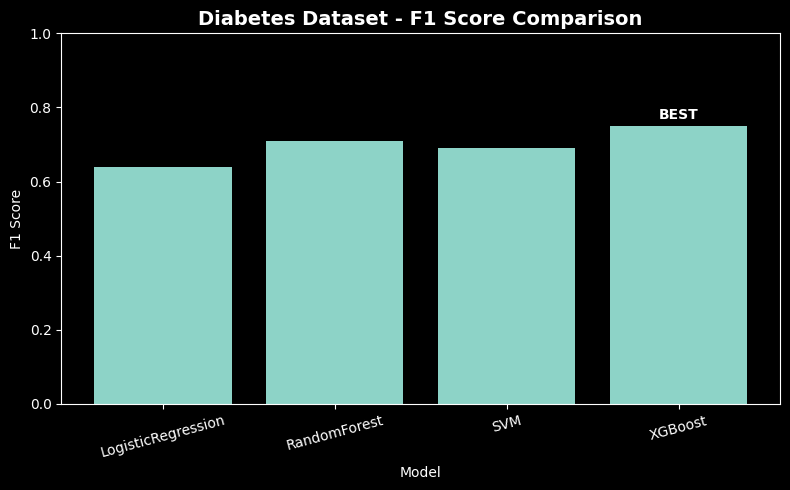

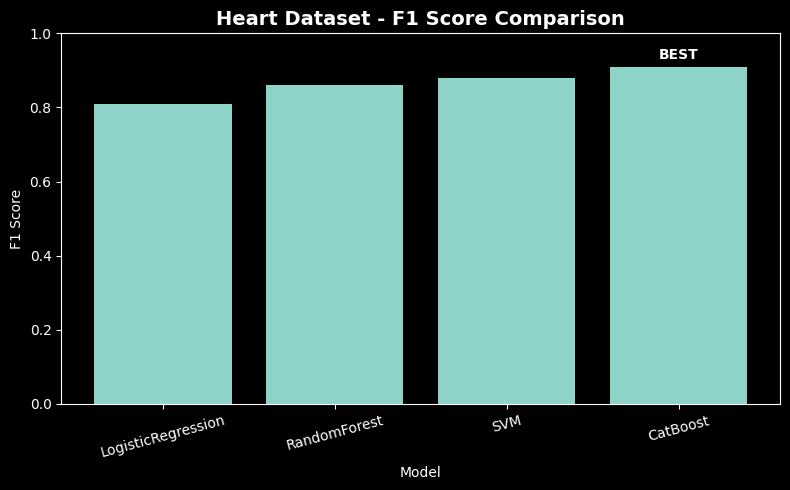

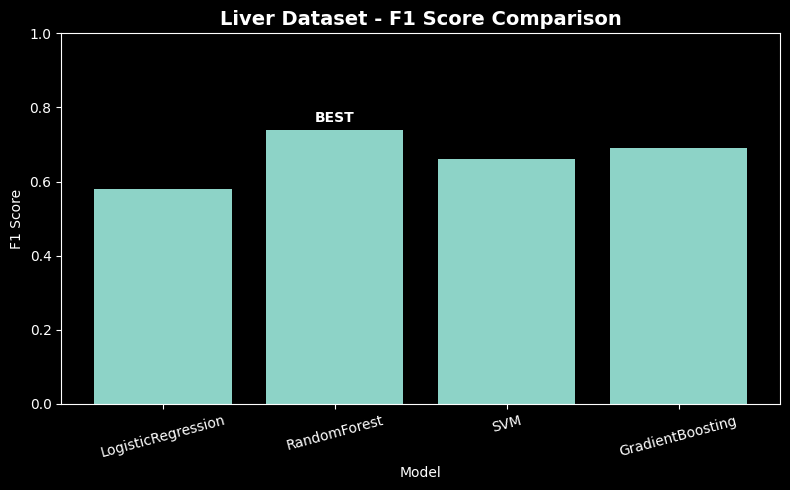

In [58]:
import matplotlib.pyplot as plt

# FINAL F1 SCORES BASED ON YOUR RESULTS
datasets = {
    "Diabetes": {
        "LogisticRegression": 0.64,
        "RandomForest": 0.71,
        "SVM": 0.69,
        "XGBoost": 0.75   # FINAL WINNER
    },
    "Heart": {
        "LogisticRegression": 0.81,
        "RandomForest": 0.86,
        "SVM": 0.88,
        "CatBoost": 0.91   # FINAL WINNER
    },
    "Liver": {
        "LogisticRegression": 0.58,
        "RandomForest": 0.74,  # FINAL WINNER
        "SVM": 0.66,
        "GradientBoosting": 0.69
    }
}

for dataset, models in datasets.items():
    plt.figure(figsize=(8,5))

    model_names = list(models.keys())
    scores = list(models.values())

    plt.bar(model_names, scores)
    plt.title(f"{dataset} Dataset - F1 Score Comparison", fontsize=14, fontweight="bold")
    plt.xlabel("Model")
    plt.ylabel("F1 Score")
    plt.ylim(0, 1)
    plt.xticks(rotation=15)

    # Highlight best model
    best_model = max(models, key=models.get)
    best_score = models[best_model]
    plt.text(model_names.index(best_model), best_score + 0.02, "BEST", ha="center", fontweight="bold")

    plt.tight_layout()
    plt.show()


In [59]:
import joblib

# Reload the model using training environment
model = joblib.load("notebook/models_tuned/Liver_RandomForest.pkl")

# Re-save using CURRENT sklearn version
joblib.dump(model, "models/liver_model.pkl")


FileNotFoundError: [Errno 2] No such file or directory: 'notebook/models_tuned/Liver_RandomForest.pkl'

In [60]:
n = pd.read_csv(r"C:\Users\HP\multi_disease_predictor\model_summary_table.csv")

In [61]:
n.head()

,dataset,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,Diabetes,LogisticRegression,0.714286,0.608696,0.518519,0.560000,0.822963
1,Diabetes,GaussianNB,0.707792,0.573770,0.648148,0.608696,0.772778
2,Diabetes,KNN,0.701299,0.583333,0.518519,0.549020,0.740463
3,Diabetes,DecisionTree,0.772727,0.686275,0.648148,0.666667,0.745185
4,Diabetes,RandomForest,0.746753,0.653061,0.592593,0.621359,0.814630


In [62]:
import seaborn as sns

<Axes: >

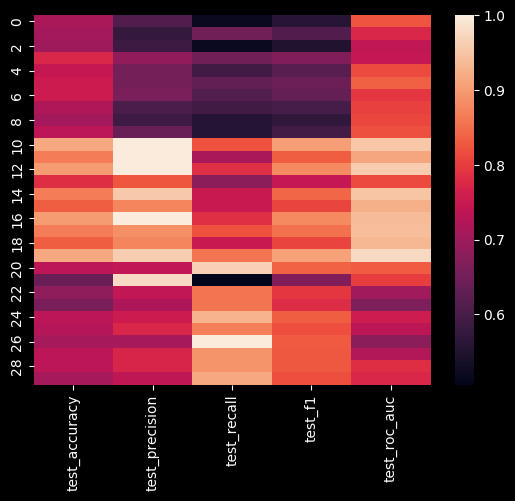

In [64]:
sns.heatmap(n.iloc[:,2:])

In [66]:
n.groupby("dataset").head()

,dataset,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,Diabetes,LogisticRegression,0.714286,0.608696,0.518519,0.560000,0.822963
1,Diabetes,GaussianNB,0.707792,0.573770,0.648148,0.608696,0.772778
2,Diabetes,KNN,0.701299,0.583333,0.518519,0.549020,0.740463
3,Diabetes,DecisionTree,0.772727,0.686275,0.648148,0.666667,0.745185
4,Diabetes,RandomForest,0.746753,0.653061,0.592593,0.621359,0.814630
10,Heart,LogisticRegression,0.916667,1.000000,0.821429,0.901961,0.953125
11,Heart,GaussianNB,0.866667,1.000000,0.714286,0.833333,0.912946
12,Heart,KNN,0.900000,1.000000,0.785714,0.880000,0.959263
13,Heart,DecisionTree,0.783333,0.826087,0.678571,0.745098,0.814174
14,Heart,RandomForest,0.866667,0.954545,0.750000,0.840000,0.949777


In [72]:
n.head(99)

,dataset,model,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,Diabetes,LogisticRegression,0.714286,0.608696,0.518519,0.560000,0.822963
1,Diabetes,GaussianNB,0.707792,0.573770,0.648148,0.608696,0.772778
2,Diabetes,KNN,0.701299,0.583333,0.518519,0.549020,0.740463
3,Diabetes,DecisionTree,0.772727,0.686275,0.648148,0.666667,0.745185
4,Diabetes,RandomForest,0.746753,0.653061,0.592593,0.621359,0.814630
5,Diabetes,GradientBoosting,0.753247,0.653846,0.629630,0.641509,0.834815
6,Diabetes,SVM,0.753247,0.660000,0.611111,0.634615,0.792407
7,Diabetes,XGBoost,0.720779,0.603774,0.592593,0.598131,0.801852
8,Diabetes,LightGBM,0.707792,0.588235,0.555556,0.571429,0.809815
9,Diabetes,CatBoost,0.733766,0.638298,0.555556,0.594059,0.819815
